# Explanation pipeline

![pipeline](pipeline2.png)

In [36]:
# Reload modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

# Import from code root directory
import sys; sys.path.insert(0, '../')

# Imports
from collections import OrderedDict
from access.amazon_doc2vec_reader import AmazonDoctovecReader
from access.amore_doc2vec_reader import AmoreDoctovecReader
from access.amore_reader import AmoreReader
from detection.bounding_boxes import BoundingBoxes
from explanations.count_explainer import CountExplainer
from explanations.tfidf_explainer import TfidfExplainer
from explanations.wordcloud import Wordcloud
from explorer.search import Search

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# Configuration
# Amazon text and embeddings directory
data_directory_amazon = '/home/eml4u/EML4U/data/amazon-complete'
# AMORE benchmark directory
data_directory_amore = '/home/eml4u/EML4U/notebooks/amore/data/benchmark-ids/'
# AMORE benchmark ID
amore_benchmark_id = '1'

## Data Readers

- Implementations of `ReaderInterface`.
- Creates `reader` instance.

In [77]:
# Amazon test 1
# 10,000 1-star items from 2007
# 10,000 5-star items from 2007
if False:
    reader = AmazonDoctovecReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['distributions_file'] = '/tmp/amore_test_1.pickle'
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

In [78]:
# Amazon test 2
# 2011: 25K positive and 25K negative
# 2012: 40K positive and 10K negative
if False:
    reader = AmazonDoctovecReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['distributions_file'] = '/tmp/amore_test_2.pickle'
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

In [79]:
# AMORE Benchmark reader
if True:
    reader = AmoreDoctovecReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['amore_directory']    = data_directory_amore
    options['amore_benchmark_id'] = amore_benchmark_id
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

AMORE directory:                    /home/eml4u/EML4U/notebooks/amore/data/benchmark-ids/
AMORE benchmark ID:                 1
AmoreDoctovecReader data directory: /home/eml4u/EML4U/data/amazon-complete
AmazonPickleReader: Reading raw data
AmazonPickleReader: Reading bow50 data


## Distribution information

In [80]:
distribution_a_id = reader.get_distribution_ids()[0]
distribution_b_id = reader.get_distribution_ids()[1]

print('Distribution IDs:', distribution_a_id, distribution_b_id)
print('Size', str(distribution_a_id) + ':', len(reader.get_item_ids(distribution_a_id)))
print('Size', str(distribution_b_id) + ':', len(reader.get_item_ids(distribution_b_id)))
print('Dimensions:', reader.get_dimensions())

Distribution IDs: 0 1
Size 0: 10000
Size 1: 10000
Dimensions: 50


## Drift Detectors

Implementations of `DetectionInterface`.

In [81]:
# Gets outliers based on boundaries derived from single dimension values.
detector = BoundingBoxes()
detector.initialize({
    'percentile':          0.995,
    'enclosed_dimensions': 50
})
detector.set_reader(reader)

BoundingBoxes percentile:                            0.995
BoundingBoxes minimum number of enclosed dimensions: 50


In [82]:
# Detect drift and save results in drift_results
drift_results = OrderedDict()
drift_results[distribution_a_id] = detector.select_item_ids(distribution_a_id, distribution_b_id)
drift_results[distribution_b_id] = detector.select_item_ids(distribution_b_id, distribution_a_id)
print('Drift result IDs:', drift_results.keys())
print('Drift result numbers of items ' + str(distribution_a_id) + ':', len(drift_results[distribution_a_id]), '/', len(reader.get_item_ids(distribution_a_id)), end='')
print(' (' + str(round(100*len(drift_results[distribution_a_id])/len(reader.get_item_ids(distribution_a_id)), 2)), '%)')
if False:
    print('Drift result numbers of items ' + str(distribution_b_id) + ':', len(drift_results[distribution_b_id]), '/', len(reader.get_item_ids(distribution_b_id)), end='')
    print(' (' + str(round(100*len(drift_results[distribution_b_id])/len(reader.get_item_ids(distribution_b_id)), 2)), '%)')

BoundingBoxes: Collecting values of single dimensions
BoundingBoxes: Updating boundaries
BoundingBoxes: Filtering items
BoundingBoxes: Collecting values of single dimensions
BoundingBoxes: Updating boundaries
BoundingBoxes: Filtering items
Drift result IDs: odict_keys([0, 1])
Drift result numbers of items 0: 4535 / 10000 (45.35 %)


In [83]:
# Loads perfect results
if False:
    #dataset_id = '1'
    dataset_id = '2'
    amore_reader = AmoreReader(data_directory=data_directory_amore)
    drift_results[distribution_a_id] = amore_reader.get_drift_ids(dataset_id, subset=None)
    print('Size of perfect results:', len(drift_results[distribution_a_id]))
    print('Token base of perfect results:', amore_reader.get_drift_tokens(dataset_id, subset=None))
    del data_directory
    del dataset_id

## Drift Explainers

Note: TF-IDF values of tokens in single detected documents are just summed up in the current version.

In [84]:
if True:
    explainer = TfidfExplainer()
    explainer.initialize({'max_results':50})

TfidfExplainer max_results: 50


In [85]:
if False:
    explainer = CountExplainer()
    explainer.initialize({'max_results':50})

In [86]:
token_dict_a = explainer.get_token_dict(drift_results[distribution_a_id], drift_results[distribution_b_id], reader)
print(token_dict_a)

{'great': 0.0008309829909166792, 'best': 0.0006644910411255474, 'love': 0.0005971876796828292, 'dvd': 0.0005221620501821107, 'season': 0.0005182834853616275, 'excellent': 0.0004628614643622581, 'time': 0.00033613541216198466, 'episodes': 0.00031543140135925304, 'just': 0.0003048690215386137, 'episode': 0.0002570440698412682, 'life': 0.0002516794100105254, 'really': 0.0002486173249097159, 'horror': 0.00023234239815181357, 'new': 0.0002261554602110313, 'reviews': 0.00021679010828678797, 'set': 0.00021620018897514423, 'performance': 0.00021485931811123524, 'people': 0.00021321601820395843, 'concert': 0.0002124483661680795, 'watching': 0.00019431032556699616, 'band': 0.00018877535234180273, 'disc': 0.0001830176937724232, 'like': 0.00018212797012699157, 'make': 0.00018085072556801808, 'bad': 0.00017980727622071832, 'way': 0.00017978213772061678, 'don': 0.0001788479198212569, 'money': 0.00017783774281557568, 'dark': 0.00017697772211127253, 'lot': 0.0001718676554057863, 'songs': 0.00017177782

In [87]:
if False:
    token_dict_b = explainer.get_token_dict(drift_results[distribution_b_id], drift_results[distribution_a_id], reader)
    print(token_dict_b)

### Verify

In [88]:
amore_reader = AmoreReader(data_directory=data_directory_amore)
drift_ids = amore_reader.get_drift_ids(amore_benchmark_id, subset=None)
print('drift_ids', len(drift_ids))
detected_ids = drift_results[distribution_a_id]
print('detected_ids', len(detected_ids))
tp = list(set(drift_ids).intersection(drift_results[distribution_a_id]))
print('tp', len(tp))
#fp = detected_ids - drift_ids
fp = [i for i in detected_ids if i not in drift_ids]
print('fp', len(fp))

#tn = 
# non-drift-ids = distribution_b_id
# note: maybe only the tp should count. correct drift docs can not be determined 100%, i think.

drift_ids 1000
detected_ids 4535
tp 691
fp 3844


In [89]:
drift_tokens = amore_reader.get_drift_tokens(amore_benchmark_id, subset=None)
print('drift_tokens', drift_tokens)
top_computed_tokens = list(token_dict_a.keys())[:len(drift_tokens)]
print('top_computed_tokens', top_computed_tokens)

# note: how many tokens would be best to compare?

drift_tokens ['excellent', 'best', 'great', 'love']
top_computed_tokens ['great', 'best', 'love', 'dvd']


### Visual representations

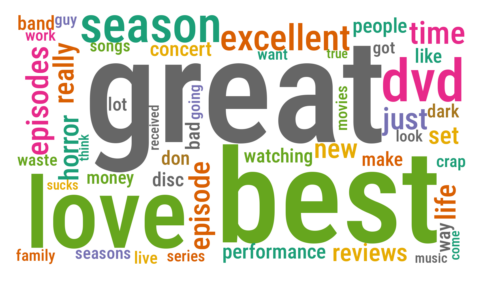

In [90]:
wordcloud = Wordcloud()
wordcloud.plot(wordcloud.get_wordcloud(token_dict_a))

In [22]:
if False:
    wordcloud = Wordcloud()
    wordcloud.plot(wordcloud.get_wordcloud(token_dict_b))

## Explorer

In [16]:
search = Search()
search.initialize({'reader':reader})

In [17]:
query = 'season'

In [18]:
search_results_a = search.search(query, item_ids=drift_results[distribution_a_id], max=-1)

Searched in 4535 items
Found 191 items (4.21 %)


In [19]:
search_results_b = search.search(query, item_ids=drift_results[distribution_b_id], max=-1)

Searched in 4160 items
Found 69 items (1.66 %)


In [20]:
# Print item IDs and texts
#search.print_results(search_results_a, max=10)

In [21]:
# Print item IDs and texts
#search.print_results(search_results_b, max=10)